In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [3]:
data = pd.read_csv("labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: >

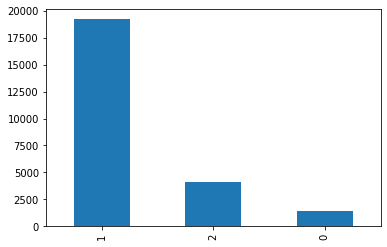

In [4]:
data['class'].value_counts().plot(kind="bar")

In [5]:
stopword=set(stopwords.words('english'))
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [w for w in text.split(' ') if w not in stopword and w!='']
    return ' '.join(text)

In [6]:
data['tweet'][999], clean(data['tweet'][999])

('&#128514;&#128514;&#128514;&#128514;&#128514;&#128514; RT @KarltonHinez: @ItsNotHarold smh bitch sellin her ass',
 'rt karltonhinez itsnotharold smh bitch sellin ass')

In [7]:
data['text'] = data['tweet'].apply(clean)

# word2vec

In [8]:
from gensim.models import Word2Vec

In [9]:
model = Word2Vec(data['text'].apply(lambda x:x.split(' ')), min_count=1, vector_size=100, window=5)

In [10]:
model.wv.index_to_key

['bitch',
 'rt',
 'bitches',
 'like',
 'hoes',
 'pussy',
 'im',
 'hoe',
 'dont',
 'ass',
 'get',
 'fuck',
 'got',
 'u',
 'shit',
 'nigga',
 'aint',
 'trash',
 'lol',
 'amp',
 'know',
 'niggas',
 'one',
 'love',
 'cant',
 'yall',
 'fucking',
 'go',
 'yo',
 'thats',
 'want',
 'bad',
 'youre',
 'good',
 'man',
 'still',
 'make',
 'say',
 'ya',
 'hate',
 'look',
 'see',
 'think',
 'need',
 'back',
 'never',
 'time',
 'faggot',
 'really',
 'people',
 'girl',
 'real',
 'right',
 'even',
 'said',
 'would',
 'white',
 'lmao',
 'bird',
 'wit',
 'wanna',
 'let',
 'bout',
 'day',
 'dick',
 'stop',
 'damn',
 'little',
 'tell',
 'call',
 'talk',
 'gotta',
 'da',
 'come',
 'ill',
 'yankees',
 'take',
 'new',
 'gonna',
 'cause',
 'life',
 'dat',
 'every',
 'always',
 'charlie',
 'going',
 'niggah',
 'better',
 'money',
 'lil',
 'girls',
 'give',
 'eat',
 'ghetto',
 'n',
 'dumb',
 'ever',
 'retarded',
 'fuckin',
 'ugly',
 'yellow',
 'talking',
 'cunt',
 'twitter',
 'put',
 'big',
 'ur',
 'stupid',
 'g

# fasttext

In [11]:
from gensim.models.fasttext import FastText

In [12]:
model2 = FastText(data['text'].apply(lambda x:x.split(' ')), vector_size=100, window=5, min_count=1)

In [13]:
model2.wv.get_vector('flammable')

array([-0.28252253,  0.12535071, -0.18512143,  0.46401244,  0.4105452 ,
        0.3104361 , -0.09712313,  0.46804613,  0.46503285, -0.5258505 ,
       -0.3981524 ,  0.07592835, -0.1923105 ,  0.67955893,  0.11441363,
       -0.07333421,  0.2485459 , -0.10759756, -0.25256148, -0.8082125 ,
       -0.37023532,  0.06402481, -0.25242463,  0.07514691, -0.2770286 ,
       -0.4602199 ,  0.05761417,  0.03463593,  0.6941859 ,  0.08614451,
       -0.19045855, -0.07035255,  0.32582787,  0.08558416, -0.06856532,
        0.25888416,  0.13968025,  0.36715806, -0.43609434,  0.27627176,
        0.3917906 , -0.29998842, -0.11406697, -0.5307541 , -0.45953304,
       -0.3691646 , -0.4491755 , -0.00688229,  0.2245794 ,  0.14187126,
        0.05411168, -0.15583903,  0.6812792 ,  0.34071508, -0.21697079,
       -0.1590324 , -0.05804697,  0.1803364 , -0.13452648, -0.01950917,
        0.05090524, -0.08156101, -0.5007298 ,  0.6254628 ,  0.08616769,
        0.4777317 , -0.18516289, -0.2753657 , -0.11571996,  0.52

#  CNN

In [14]:
words = ["<PAD>"]
x = []
for sent in data['text']:
    tmp = []
    for w in sent.split(' '):
        if w not in words:
            words.append(w)
        tmp.append(words.index(w))
    x.append(torch.tensor(tmp))

In [15]:
X = pad_sequence(x, batch_first=True, padding_value=0)
X.shape

torch.Size([24783, 25])

In [16]:
class CNN(nn.Module):
    def __init__(self, vocab_dim):
        super(CNN, self).__init__()
        emb_dim = 100
        self.emb = nn.Embedding(vocab_dim, emb_dim)
        self.conv = nn.Conv1d(emb_dim, 64, 3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 2)
    
    def forward(self, x):
        x = self.emb(x)
        x = self.conv(x.permute(0,2,1))
        x = self.pool(torch.relu(x)).squeeze(2)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [17]:
mod = CNN(len(words))
out = mod(X)

In [18]:
out.shape

torch.Size([24783, 2])

In [19]:
y = data['class'].copy()
y[y==2] = 1
y = torch.from_numpy(pd.get_dummies(y).values)
y = y.float()
y.shape, y.dtype

(torch.Size([24783, 2]), torch.float32)

In [20]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mod.parameters(), lr=0.01)

In [21]:
for epoch in range(10):
    mod.train()
    optimizer.zero_grad()
    
    out = mod(X)
    loss = criterion(out, y)
    
    loss.backward()
    optimizer.step()
    
    print("epoch:",epoch, " loss:", loss, "prediction:", out[:5,:])

epoch: 0  loss: tensor(0.7249, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.5231, 0.5990],
        [0.4527, 0.4834],
        [0.5545, 0.4839],
        [0.5250, 0.4968],
        [0.5591, 0.4844]], grad_fn=<SliceBackward0>)
epoch: 1  loss: tensor(0.2203, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0924, 0.9482],
        [0.0629, 0.9405],
        [0.0671, 0.9382],
        [0.0643, 0.9465],
        [0.1132, 0.9204]], grad_fn=<SliceBackward0>)
epoch: 2  loss: tensor(0.2959, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0080, 0.9960],
        [0.0048, 0.9963],
        [0.0044, 0.9963],
        [0.0049, 0.9964],
        [0.0094, 0.9947]], grad_fn=<SliceBackward0>)
epoch: 3  loss: tensor(0.3289, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0033, 0.9978],
        [0.0020, 0.9981],
        [0.0017, 0.9983],
        [0.0021, 0.9982],
        [0.0034, 0.9973]], grad_fn=<SliceBackward0>)
epoch: 4  loss: tensor(0.3057, grad_fn=<Bina

In [22]:
pred = np.argmax(out.detach().numpy(), axis=1)
ytst = np.argmax(y, axis=1)
cm = confusion_matrix(pred, ytst)
cm

array([[    0,     0],
       [ 1430, 23353]], dtype=int64)

Class imbalance issue

## RNN

In [23]:
class RNN(nn.Module):
    def __init__(self, vocab_dim, seq_len):
        super(RNN, self).__init__()
        emb_dim = 100
        self.emb = nn.Embedding(vocab_dim, emb_dim)
        self.rnn = nn.RNN(emb_dim, 100)
        self.fc = nn.Linear(100, 2)
    
    def forward(self, x):
        x = self.emb(x)
        _,x = self.rnn(x.permute(1,0,2))
        x = self.fc(x).squeeze(0)
        return torch.sigmoid(x)

In [24]:
mod = RNN(len(words), X.shape[1])
out = mod(X)
out.shape

torch.Size([24783, 2])

In [25]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mod.parameters(), lr=0.01)

In [26]:
for epoch in range(10):
    mod.train()
    optimizer.zero_grad()
    
    out = mod(X)
    loss = criterion(out, y)
    
    loss.backward()
    optimizer.step()
    
    print("epoch:",epoch, " loss:", loss, "prediction:", out[:5,:])

epoch: 0  loss: tensor(0.7115, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.4816, 0.4629],
        [0.4816, 0.4629],
        [0.4816, 0.4629],
        [0.4816, 0.4629],
        [0.4816, 0.4629]], grad_fn=<SliceBackward0>)
epoch: 1  loss: tensor(0.2301, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0950, 0.9041],
        [0.0950, 0.9041],
        [0.0950, 0.9041],
        [0.0950, 0.9041],
        [0.0950, 0.9041]], grad_fn=<SliceBackward0>)
epoch: 2  loss: tensor(0.2235, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0414, 0.9578],
        [0.0414, 0.9578],
        [0.0414, 0.9578],
        [0.0414, 0.9578],
        [0.0414, 0.9578]], grad_fn=<SliceBackward0>)
epoch: 3  loss: tensor(0.2272, grad_fn=<BinaryCrossEntropyBackward0>) prediction: tensor([[0.0350, 0.9654],
        [0.0350, 0.9654],
        [0.0350, 0.9654],
        [0.0350, 0.9654],
        [0.0350, 0.9654]], grad_fn=<SliceBackward0>)
epoch: 4  loss: tensor(0.2241, grad_fn=<Bina

class imbalance issue

## Word2Vec classification

In [41]:
model.wv.add_vector('<PAD>', np.zeros(100))

C:\Users\JAYANKONDAN\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


30154

In [47]:
words

['<PAD>',
 'rt',
 'mayasolovely',
 'woman',
 'shouldnt',
 'complain',
 'cleaning',
 'house',
 'amp',
 'man',
 'always',
 'take',
 'trash',
 'boy',
 'dats',
 'coldtyga',
 'dwn',
 'bad',
 'cuffin',
 'dat',
 'hoe',
 'place',
 'urkindofbrand',
 'dawg',
 'ever',
 'fuck',
 'bitch',
 'start',
 'cry',
 'confused',
 'shit',
 'cganderson',
 'vivabased',
 'look',
 'like',
 'tranny',
 'shenikaroberts',
 'hear',
 'might',
 'true',
 'faker',
 'told',
 'ya',
 'tmadisonx',
 'blows',
 'meclaim',
 'faithful',
 'somebody',
 'still',
 'fucking',
 'hoes',
 'brighterdays',
 'sit',
 'hate',
 'another',
 'got',
 'much',
 'going',
 'cause',
 'im',
 'tired',
 'big',
 'bitches',
 'coming',
 'us',
 'skinny',
 'get',
 'back',
 'thats',
 'rhythmixx',
 'hobbies',
 'include',
 'fighting',
 'mariambitch',
 'keeks',
 'curves',
 'everyone',
 'lol',
 'walked',
 'conversation',
 'smh',
 'murda',
 'gang',
 'land',
 'smoke',
 'losers',
 'yea',
 'go',
 'ig',
 'thing',
 'nigga',
 'miss',
 'plz',
 'whatever',
 'love',
 'cut',


In [35]:
X

tensor([[    1,     2,     3,  ...,     0,     0,     0],
        [    1,    13,    14,  ...,     0,     0,     0],
        [    1,    22,    23,  ...,     0,     0,     0],
        ...,
        [  223,  5474,   249,  ...,     0,     0,     0],
        [14198,    55,  3287,  ...,     0,     0,     0],
        [14855, 30151, 30152,  ...,     0,     0,     0]])

In [48]:
vectors = [[model.wv.get_vector(words[wrd]) for wrd in sent] for sent in X]

In [50]:
vectors = np.array(vectors)
vectors.shape

(24783, 25, 100)

In [57]:
y = data['class'].values
y

array([2, 1, 1, ..., 1, 1, 2], dtype=int64)

In [61]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])  # Take the output of the last time step
        return output

In [73]:
model = SimpleLSTM(100, 50, 1, 3)

In [76]:
vectors = torch.from_numpy(vectors)
y = torch.from_numpy(y)

In [77]:
out = model(vectors)
out.shape

torch.Size([24783, 3])

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [79]:
criterion(out, y)

tensor(1.0672, grad_fn=<NllLossBackward0>)

In [83]:
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(vectors[:10000])
    loss = criterion(outputs, y[:10000])
    loss.backward()
    optimizer.step()
    print("epoch:",epoch, " loss:", loss, "prediction:", out[:5,:])

epoch: 0  loss: tensor(0.8566, grad_fn=<NllLossBackward0>) prediction: tensor([[ 0.0490,  0.0890, -0.0422],
        [ 0.0487,  0.0893, -0.0423],
        [ 0.0488,  0.0892, -0.0423],
        [ 0.0486,  0.0894, -0.0423],
        [ 0.0488,  0.0892, -0.0423]], grad_fn=<SliceBackward0>)
epoch: 1  loss: tensor(0.7457, grad_fn=<NllLossBackward0>) prediction: tensor([[ 0.0490,  0.0890, -0.0422],
        [ 0.0487,  0.0893, -0.0423],
        [ 0.0488,  0.0892, -0.0423],
        [ 0.0486,  0.0894, -0.0423],
        [ 0.0488,  0.0892, -0.0423]], grad_fn=<SliceBackward0>)
epoch: 2  loss: tensor(0.8198, grad_fn=<NllLossBackward0>) prediction: tensor([[ 0.0490,  0.0890, -0.0422],
        [ 0.0487,  0.0893, -0.0423],
        [ 0.0488,  0.0892, -0.0423],
        [ 0.0486,  0.0894, -0.0423],
        [ 0.0488,  0.0892, -0.0423]], grad_fn=<SliceBackward0>)
epoch: 3  loss: tensor(0.7978, grad_fn=<NllLossBackward0>) prediction: tensor([[ 0.0490,  0.0890, -0.0422],
        [ 0.0487,  0.0893, -0.0423],
      